# Setup

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../t-recs/')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import *
from wrapper.metrics.cheney_metrics import MeanInteractionDistance, MeanDistanceSimUsers

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_12451/636986060.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [144]:
n_attrs=20
max_iter=1000
n_clusters=25

In [145]:
score_fn = 'cosine_sim'#'myopic' #'content_fairness'
probabilistic = False
globals.ALPHA = 0.2
alpha = globals.ALPHA

# User parameters
drift = 0.5
attention_exp=-0.8

In [146]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

num_users = user_representation.shape[0]
num_items = item_representation.shape[1]
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

# Create user_pairs by pairing users only with others that are not in the same cluster
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
experiment_name = 'users_by_topic'
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded embeddings.
Loaded clusters.
Loaded clusters.
Number of items: 1682
Number of users: 943


# Simulation

In [147]:
mse = MSEMeasurement()
measurements = [
    InteractionMeasurement(),
    MSEMeasurement(),  
    InteractionSpread(),                
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    RecSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_rec_similarity'), 
    RecSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_rec_similarity'), 
    UserMSEMeasurement(),
    RecallMeasurement(),
    MeanNumberOfTopics(),
    # Cheney measurements *******
    MeanInteractionDistance(pairs=inter_cluster_user_pairs, name='inter_cluster_mean_interaction_distance'), 
    MeanInteractionDistance(pairs=intra_cluster_user_pairs, name='intra_cluster_mean_interaction_distance'), 
    # ***************************
]

In [148]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_cluster_ids,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [149]:
model = BubbleBurster(**config)

model.add_metrics(*measurements)

In [150]:
# Train model
train_timesteps=5
print("Training {model_name}, {train_timesteps} timesteps")
model.startup_and_train(timesteps=train_timesteps)

# Run model
run_timesteps=20
print("Training {model_name}, {run_timesteps} timesteps")
model.run(timesteps=run_timesteps)

Training {model_name}, {train_timesteps} timesteps


100%|██████████| 5/5 [01:02<00:00, 12.59s/it]


Training {model_name}, {run_timesteps} timesteps


100%|██████████| 20/20 [05:24<00:00, 16.22s/it]


In [151]:
measurements = model.get_measurements()

for k in measurements.keys():
    print(k)

interaction_histogram
mse
interaction_spread
inter_cluster_interaction_similarity
intra_cluster_interaction_similarity
inter_cluster_rec_similarity
intra_cluster_rec_similarity
user_mse
recall_at_k
mean_num_topics
inter_cluster_mean_interaction_distance
intra_cluster_mean_interaction_distance
timesteps


In [152]:
df_measurements = pd.DataFrame(measurements)
df_measurements.head(5)

,interaction_histogram,mse,interaction_spread,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,inter_cluster_rec_similarity,intra_cluster_rec_similarity,user_mse,recall_at_k,mean_num_topics,inter_cluster_mean_interaction_distance,intra_cluster_mean_interaction_distance,timesteps
0,None,0.090065,NaN,NaN,NaN,NaN,NaN,"[0.0351226880773755, 0.08176822920068769, 0.16...",NaN,NaN,NaN,NaN,0
1,"[6.0, 0.0, 1.0, 3.0, 2.0, 1.0, 5.0, 1.0, 4.0, ...",0.132665,-939.0,0.001247,0.003658,0.003169,0.005219,"[0.16487935363367803, 0.12666511430750205, 0.1...",0.943796,1.0,2.412032,2.517608,1
2,"[1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, ...",0.150954,-0.5,0.001632,0.004067,0.003100,0.005164,"[0.17247141137741148, 0.21093427579864688, 0.1...",0.959703,2.0,1.854877,1.928763,2
3,"[2.0, 0.0, 2.0, 3.0, 1.0, 0.0, 5.0, 1.0, 0.0, ...",0.160055,0.0,0.002326,0.004650,0.003137,0.005175,"[0.15995388360787893, 0.22142907111712828, 0.1...",0.945917,3.0,1.634835,1.682443,3
4,"[1.0, 3.0, 3.0, 2.0, 2.0, 1.0, 0.0, 4.0, 1.0, ...",0.163718,-0.5,0.003003,0.005283,0.003093,0.005207,"[0.12287265166186237, 0.13196665691718543, 0.1...",0.942736,4.0,1.464202,1.486433,4


In [153]:
## *************************************************************
## Saving measurement dataframe to CSV *************************
## *************************************************************

import src
reload(src.utils)
from src.utils import *
    
# Determine file name based on parameter values
parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
if requires_alpha:
    parameters += f'_{alpha}Lambda'

# Save actual user preferences
final_preferences_dir = 'artefacts/supplementary/final_preferences/'
file_prefix = f'{model_name}_final_preferences'
final_preferences_path = final_preferences_dir + file_prefix + parameters + '.npy'
np.save(final_preferences_path, model.users.actual_user_profiles.value, allow_pickle=True)

# Save measurements
measurements_dir = f'artefacts/supplementary/measurements/'
file_prefix = f'{model_name}_measurements'

measurements_path = measurements_dir + file_prefix + parameters + '.csv'
# np.set_printoptions(threshold=sys.maxsize)
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
# measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()
# saving interaction histogram
path_interaction_histogram = f'{measurements_dir}{model_name}_interaction_histogram{parameters}.csv'
interaction_hist = measurements_df['interaction_histogram'].copy()
interaction_hist[0] = np.repeat(np.nan, interaction_hist[1].shape[0], axis=0)
interaction_hist = np.stack(interaction_hist.values)
test = pd.DataFrame(interaction_hist)
test.to_csv(path_interaction_histogram, index=False)
# saving use_mse histogram
path_user_mse_histogram = f'{measurements_dir}{model_name}_user_mse_histogram{parameters}.csv'
user_mse = measurements_df['user_mse'].copy()
user_mse = np.stack(user_mse.values)
test = pd.DataFrame(user_mse)
test.to_csv(path_user_mse_histogram, index=False)
# saving all measurements
measurements_df.to_csv(measurements_path, index=False)
print('Measurements saved.')

Measurements saved.


In [154]:
for col in df_measurements.columns:
    print(col)

interaction_histogram
mse
interaction_spread
inter_cluster_interaction_similarity
intra_cluster_interaction_similarity
inter_cluster_rec_similarity
intra_cluster_rec_similarity
user_mse
recall_at_k
mean_num_topics
inter_cluster_mean_interaction_distance
intra_cluster_mean_interaction_distance
timesteps


In [155]:
def plot_measurements_1_df(df, model_name):
    fig, ax = plt.subplots(3, 4, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    ts = df['timesteps'].values
    
    cols_exclude = ['timesteps', 'interaction_histogram', 'user_mse']
    
    # if not requires_alpha:
    #     alpha = np.nan
    alpha=0.5
        
    # mse
    ax[0,0].plot(ts, df['mse'], label=model_name)
    ax[0,0].set_title('Mean Squared Error')
    ax[0,0].set_ylabel('MSE')
    # recall_at_k
    ax[0,1].plot(ts, df['recall_at_k'], label=model_name)
    ax[0,1].set_title('Recall at k')
    ax[0,1].set_ylabel('Recall')
    # interaction_spread
    ax[0,2].plot(ts, df['interaction_spread'], label=model_name, alpha=alpha)
    ax[0,2].set_title('Interaction Spread')
    ax[0,2].set_ylabel('Jaccard Similarity')
    ax[0,3].axis('off')
    
    # inter_cluster_interaction_similarity
    ax[1,0].plot(ts, df['inter_cluster_interaction_similarity'], label=model_name, alpha=alpha)
    ax[1,0].set_title('Inter-cluster interaction similarity')
    ax[1,0].set_ylabel('Jaccard Similarity')
    # intra_cluster_interaction_similarity
    ax[1,1].plot(ts, df['intra_cluster_interaction_similarity'], label=model_name, alpha=alpha)
    ax[1,1].set_title('Intra-cluster interaction similarity')
    ax[1,1].set_ylabel('Jaccard Similarity')
    # inter_cluster_rec_similarity
    ax[1,2].plot(ts, df['inter_cluster_rec_similarity'], label=model_name, alpha=alpha)
    ax[1,2].set_title('Inter-cluster interaction similarity')
    ax[1,2].set_ylabel('Jaccard Similarity')
    # intra_cluster_rec_similarity
    ax[1,3].plot(ts, df['intra_cluster_rec_similarity'], label=model_name, alpha=alpha)
    ax[1,3].set_title('Intra-cluster interaction similarity')
    ax[1,3].set_ylabel('Jaccard Similarity')
    
    # mean_num_topics
    ax[2,0].plot(ts, df['mean_num_topics'], label=model_name, alpha=alpha)
    ax[2,0].set_title('Mean number of topics interacted with per timestep')
    ax[2,0].set_ylabel('Avg. number of topics')
    # inter_cluster_mean_interaction_distance
    ax[2,1].plot(ts, df['inter_cluster_mean_interaction_distance'], label=model_name, alpha=alpha)
    ax[2,1].set_title('Inter-cluster interaction similarity')
    ax[2,1].set_ylabel('Avg. Interaction Distance')
    # intra_cluster_mean_interaction_distance
    ax[2,2].plot(ts, df['intra_cluster_mean_interaction_distance'], label=model_name, alpha=alpha)
    ax[2,2].set_title('Intra-cluster interaction similarity')
    ax[2,2].set_ylabel('Avg. Interaction Distance')
    ax[2,3].axis('off')

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    # fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

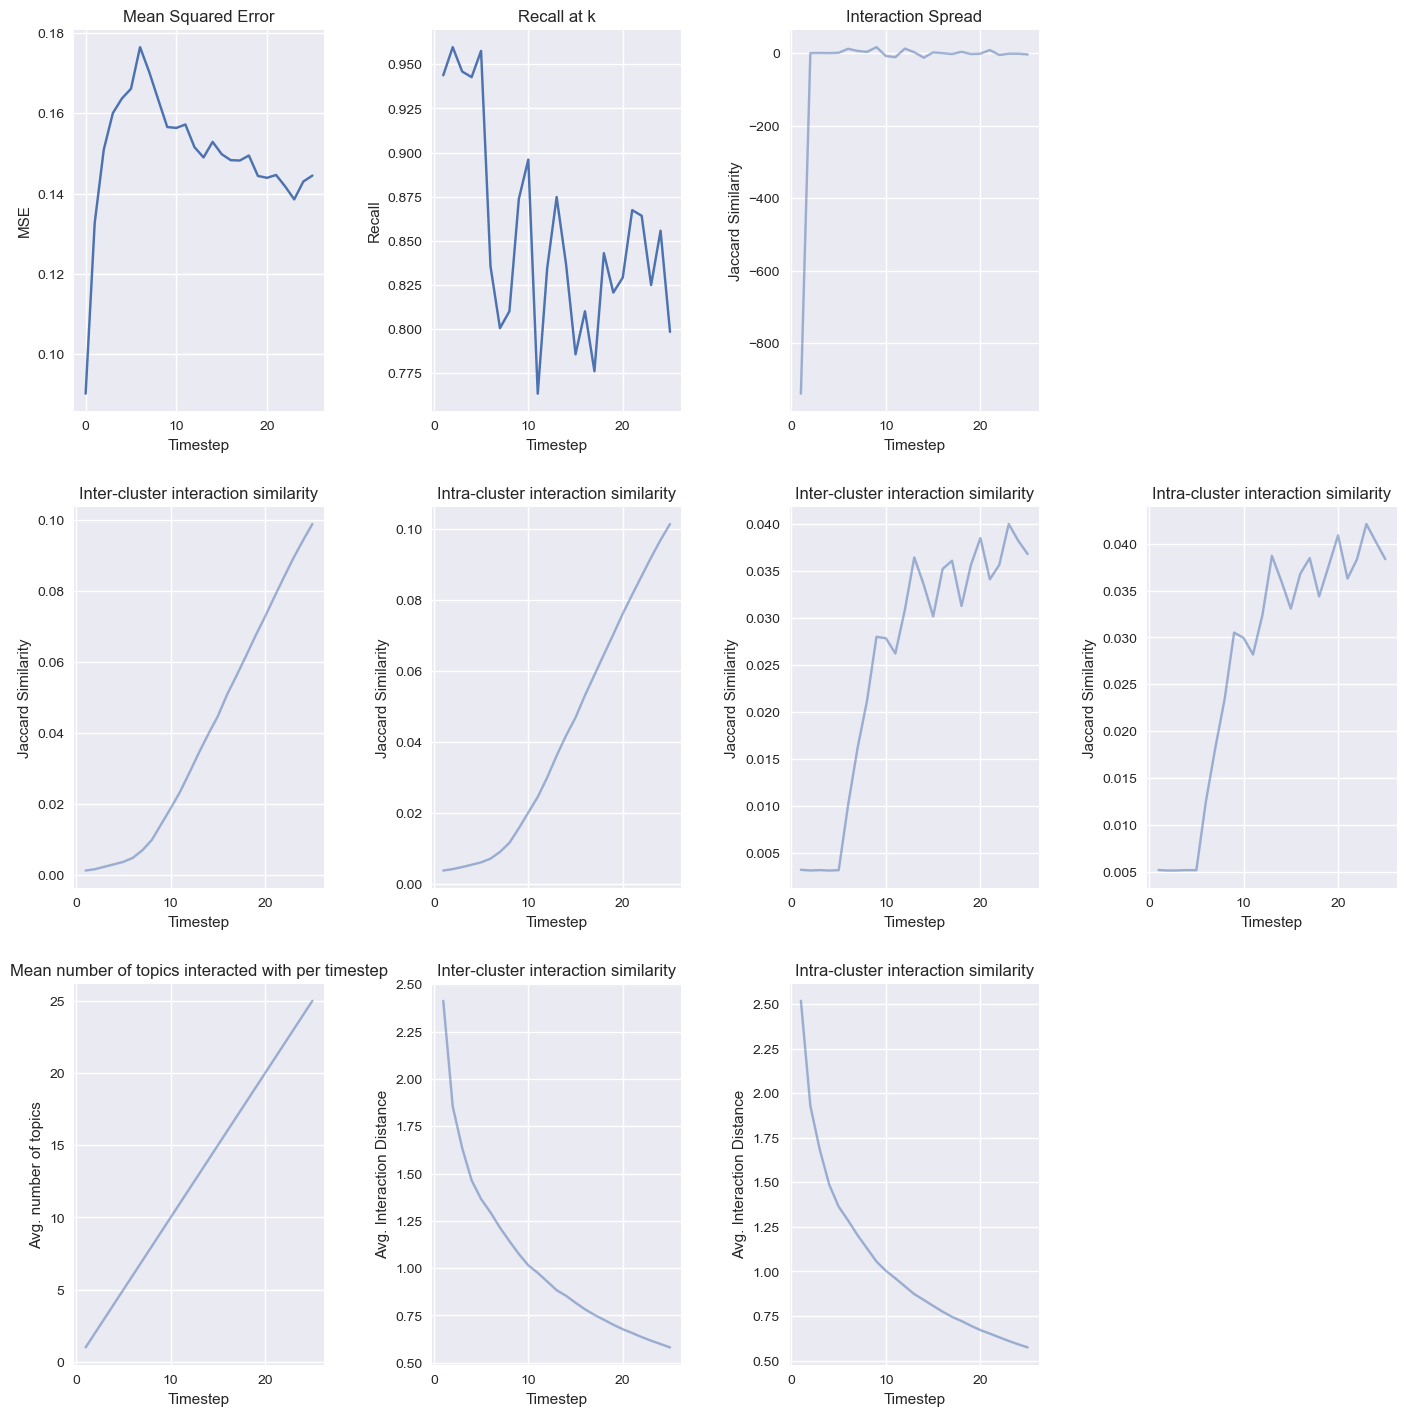

In [175]:
plot_measurements_1_df(measurements_df, model_name)

In [157]:
np.array_equal(df_measurements['intra_cluster_mean_interaction_distance'], df_measurements['inter_cluster_mean_interaction_distance'])

False

In [158]:
def plot_measurements_all_dfs(dfs, model_names):
    fig, ax = plt.subplots(3, 4, figsize=(15, 15))
    fig.tight_layout(pad=5.0)
    
    # if not requires_alpha:
    #     alpha = np.nan
    alpha=0.5
    
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = model_names[i]
        print(name)
        legend_names.append(name)
        
        # mse
        line, = ax[0,0].plot(ts, df['mse'], label=name)
        # recall_at_k
        ax[0,1].plot(ts, df['recall_at_k'], label=name)
        # interaction_spread
        ax[0,2].plot(ts, df['interaction_spread'], label=name, alpha=alpha)
        # inter_cluster_interaction_similarity
        ax[1,0].plot(ts, df['inter_cluster_interaction_similarity'], label=name, alpha=alpha)
        # intra_cluster_interaction_similarity
        ax[1,1].plot(ts, df['intra_cluster_interaction_similarity'], label=name, alpha=alpha)
        # inter_cluster_rec_similarity
        ax[1,2].plot(ts, df['inter_cluster_rec_similarity'], label=name, alpha=alpha)
        # intra_cluster_rec_similarity
        ax[1,3].plot(ts, df['intra_cluster_rec_similarity'], label=name, alpha=alpha)
        # mean_num_topics
        ax[2,0].plot(ts, df['mean_num_topics'], label=name, alpha=alpha)
        # inter_cluster_mean_interaction_distance
        ax[2,1].plot(ts, df['inter_cluster_mean_interaction_distance'], label=name, alpha=alpha)
        # intra_cluster_mean_interaction_distance
        ax[2,2].plot(ts, df['intra_cluster_mean_interaction_distance'], label=name, alpha=alpha)
        
        legend_lines.append(line)
    
    ax[0,0].set_title('Mean Squared Error')
    ax[0,0].set_ylabel('MSE')
    
    ax[0,1].set_title('Recall at k')
    ax[0,1].set_ylabel('Recall')
    
    ax[0,2].set_title('Interaction Spread')
    ax[0,2].set_ylabel('Jaccard Similarity')
    ax[0,3].axis('off')
    
    
    ax[1,0].set_title('Inter-cluster interaction similarity')
    ax[1,0].set_ylabel('Jaccard Similarity')
    
    ax[1,1].set_title('Intra-cluster interaction similarity')
    ax[1,1].set_ylabel('Jaccard Similarity')
    
    ax[1,2].set_title('inter_cluster_rec_similarity')
    ax[1,2].set_ylabel('Jaccard Similarity')
    
    ax[1,3].set_title('intra_cluster_rec_similarity')
    ax[1,3].set_ylabel('Jaccard Similarity')
    
    
    ax[2,0].set_title('Mean number of topics interacted with per timestep')
    ax[2,0].set_ylabel('Avg. number of topics')
    
    ax[2,1].set_title('Inter-cluster interaction similarity')
    ax[2,1].set_ylabel('Avg. Interaction Distance')
    
    ax[2,2].set_title('Intra-cluster interaction similarity')
    ax[2,2].set_ylabel('Avg. Interaction Distance')
    ax[2,3].axis('off')

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

cosine_sim - lambda=0.05


KeyError: 'timesteps'

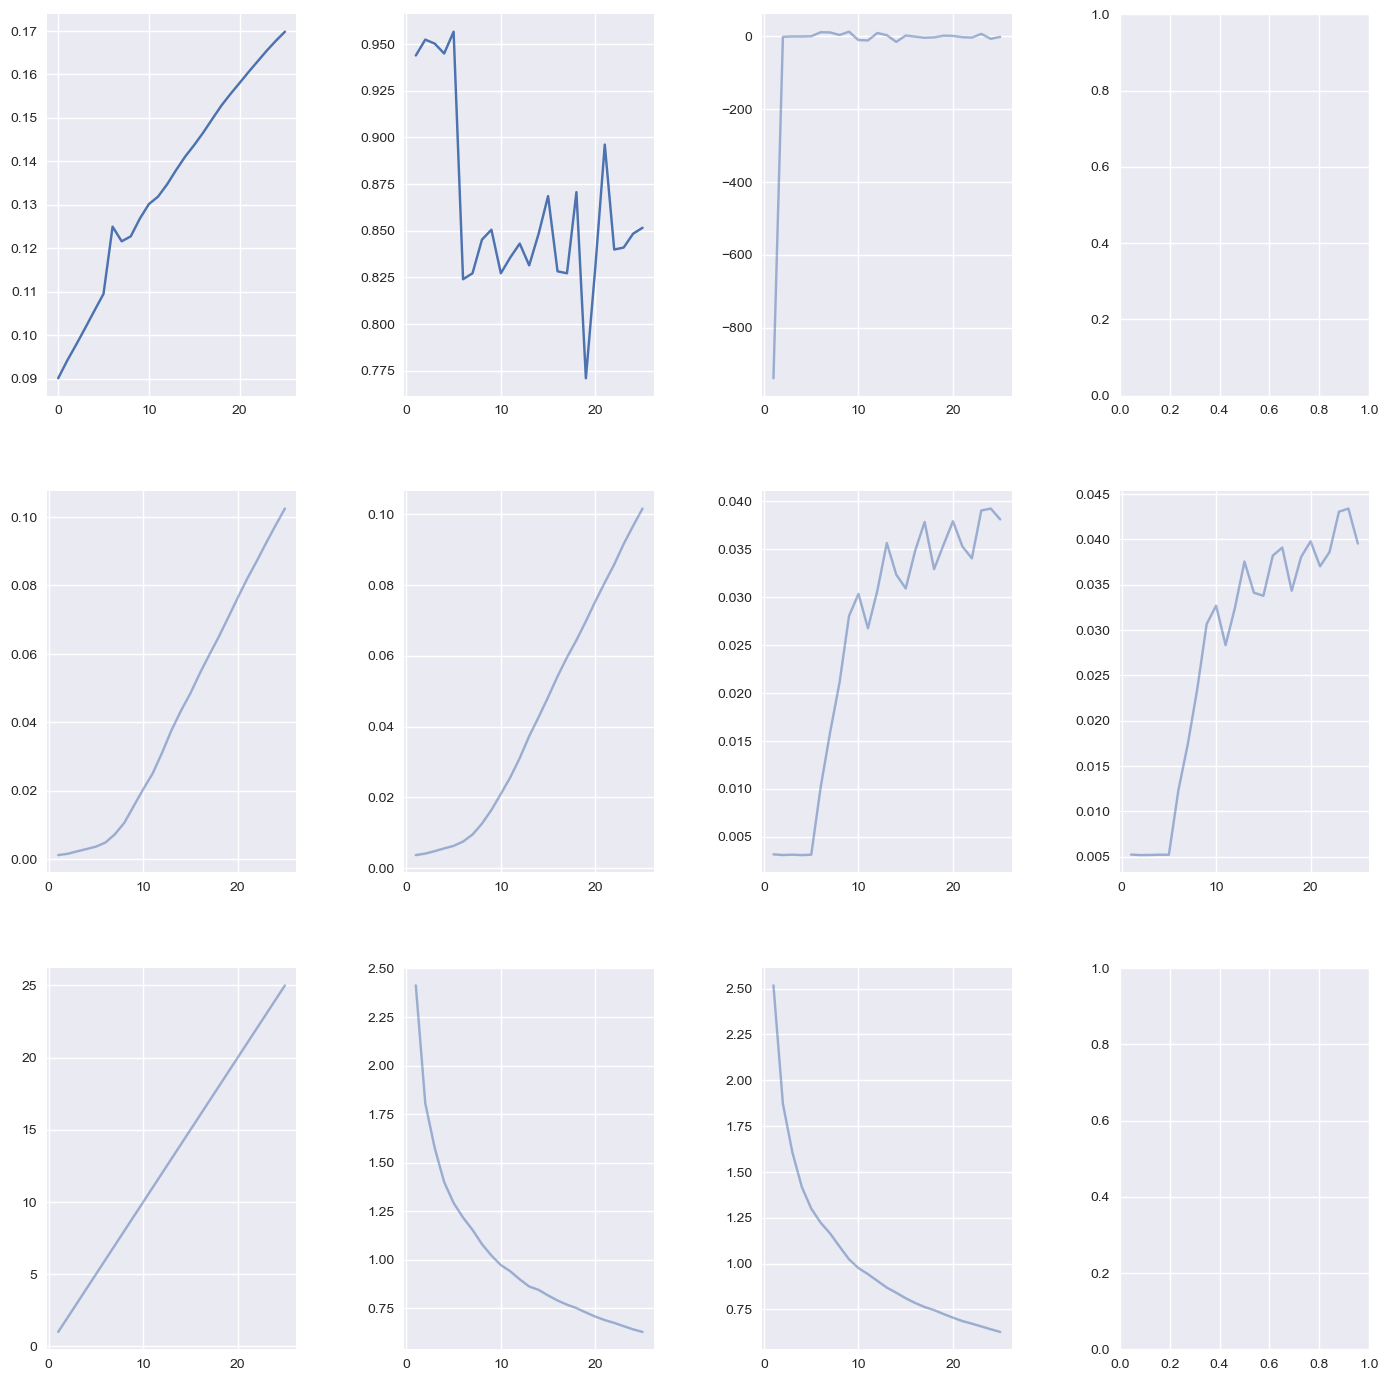

In [177]:
paths_user_mse = {
    'cosine_sim - lambda=0.05':'artefacts/supplementary/measurements/cosine_sim_measurements_5trainTimesteps_20runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.2Lambda.csv',
    'cosine_sim - lambda=0.5':'artefacts/supplementary/measurements/cosine_sim_interaction_histogram_5trainTimesteps_20runTimesteps_20nAttrs_25nClusters_0.5Drift_-0.8AttentionExp_0.2Lambda.csv',
    # 'entropy':'artefacts/supplementary/measurements/entropy_user_mse_histogram_5trainTimesteps_20runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.2Lambda.csv'
}

# fig, ax = plt.subplots(nrows=len(paths_user_mse), ncols=1)

dfs = []
model_names = ['cosine_sim - lambda=0.05', 'cosine_sim - lambda=0.05']
models = list(paths_user_mse.keys())
for i in range(len(models)):
    df = pd.read_csv(paths_user_mse[models[i]])
    dfs.append(df)

plot_measurements_all_dfs(dfs, model_names)

In [160]:
np.array_equal(dfs[0]['intra_cluster_mean_interaction_distance'], dfs[1]['intra_cluster_mean_interaction_distance'])

False

In [161]:
dfs[0]['intra_cluster_mean_interaction_distance']

0          NaN
1     2.517608
2     1.871703
3     1.607455
4     1.418337
5     1.299941
6     1.222723
7     1.164029
8     1.092704
9     1.023186
10    0.975506
11    0.942527
12    0.905683
13    0.868849
14    0.840782
15    0.810813
16    0.785011
17    0.763084
18    0.746410
19    0.724737
20    0.704962
21    0.686348
22    0.672442
23    0.657038
24    0.641791
25    0.627024
Name: intra_cluster_mean_interaction_distance, dtype: float64

In [162]:
dfs[1]['intra_cluster_mean_interaction_distance']

0          NaN
1     2.517608
2     1.871703
3     1.607455
4     1.418337
5     1.299941
6     1.221903
7     1.146011
8     1.074541
9     1.002192
10    0.936305
11    0.874643
12    0.822557
13    0.773320
14    0.732081
15    0.695442
16    0.661763
17    0.634755
18    0.609196
19    0.591334
20    0.573696
21    0.557026
22    0.543448
23    0.528205
24    0.514369
25    0.503105
Name: intra_cluster_mean_interaction_distance, dtype: float64

In [163]:
before = model.actual_user_profiles
print(before.shape)
before

(943, 20)


array([[8.91238610e-02, 2.02143994e-01, 8.93960172e-02, ...,
        5.53454517e-01, 6.63662505e-02, 3.74785168e-01],
       [7.45601239e-03, 6.71147649e-02, 2.73150261e-02, ...,
        7.13766509e-02, 1.07864467e-02, 1.22568433e-02],
       [4.74128458e-02, 2.59850910e-02, 1.91292780e-02, ...,
        5.83387502e-02, 2.58854794e-03, 3.41039065e-02],
       ...,
       [1.20045850e-03, 2.24433165e-03, 2.62937811e-02, ...,
        1.13093506e-02, 4.84466523e-03, 1.39641985e-02],
       [3.69492829e-04, 3.27775154e-02, 3.98429130e-02, ...,
        4.76091279e-02, 4.42456272e-04, 3.26688927e-03],
       [3.44352706e-02, 2.40240190e-01, 1.06082128e-01, ...,
        4.45278513e-04, 1.73794921e-02, 4.06013755e-01]])

In [164]:
# Run model
run_timesteps=20
print("Training {model_name}, {run_timesteps} timesteps")
model.run(timesteps=run_timesteps)

Training {model_name}, {run_timesteps} timesteps


100%|██████████| 20/20 [06:39<00:00, 19.95s/it]


In [165]:
after = model.actual_user_profiles
print(after.shape)
after

(943, 20)


array([[1.55486338e-03, 4.29346441e-02, 1.15994550e-02, ...,
        4.66969063e-01, 8.72231299e-01, 4.36100444e-02],
       [1.89452663e-02, 6.37509907e-02, 1.40587122e-02, ...,
        1.75976104e-01, 7.97954623e-02, 2.84040921e-01],
       [1.97244895e-03, 1.17433506e-02, 8.69087218e-04, ...,
        6.43524945e-04, 2.57192046e-02, 1.65469829e-04],
       ...,
       [1.55436348e-03, 5.68989176e-03, 5.21748592e-03, ...,
        1.29518920e-03, 4.96605966e-02, 1.27699110e-02],
       [7.71603941e-03, 3.98946707e-03, 1.81816455e-03, ...,
        8.43306123e-03, 9.58067440e-02, 8.70267466e-03],
       [3.05888266e-02, 1.27639760e-01, 3.69548835e-01, ...,
        2.79178021e-01, 7.54704043e-03, 1.15936207e+00]])

In [166]:

inter_cluster_user_pairs[-1::-1]

[(942, 935),
 (942, 933),
 (942, 931),
 (942, 918),
 (942, 917),
 (942, 915),
 (942, 912),
 (942, 902),
 (942, 896),
 (942, 895),
 (942, 893),
 (942, 891),
 (942, 888),
 (942, 886),
 (942, 885),
 (942, 884),
 (942, 883),
 (942, 882),
 (942, 881),
 (942, 880),
 (942, 879),
 (942, 877),
 (942, 876),
 (942, 874),
 (942, 869),
 (942, 867),
 (942, 863),
 (942, 862),
 (942, 861),
 (942, 860),
 (942, 853),
 (942, 847),
 (942, 845),
 (942, 842),
 (942, 839),
 (942, 832),
 (942, 828),
 (942, 827),
 (942, 822),
 (942, 814),
 (942, 806),
 (942, 805),
 (942, 804),
 (942, 803),
 (942, 797),
 (942, 795),
 (942, 794),
 (942, 787),
 (942, 785),
 (942, 781),
 (942, 772),
 (942, 765),
 (942, 762),
 (942, 757),
 (942, 755),
 (942, 751),
 (942, 750),
 (942, 748),
 (942, 746),
 (942, 732),
 (942, 726),
 (942, 720),
 (942, 715),
 (942, 714),
 (942, 711),
 (942, 710),
 (942, 706),
 (942, 704),
 (942, 698),
 (942, 693),
 (942, 689),
 (942, 681),
 (942, 665),
 (942, 663),
 (942, 662),
 (942, 660),
 (942, 658),

In [167]:
# inter_cluster_user_pairs, intra_cluster_user_pairs
from sklearn.metrics.pairwise import euclidean_distances
distances_before = euclidean_distances(before, before)
distances_before.shape

(943, 943)

In [168]:
before

array([[8.91238610e-02, 2.02143994e-01, 8.93960172e-02, ...,
        5.53454517e-01, 6.63662505e-02, 3.74785168e-01],
       [7.45601239e-03, 6.71147649e-02, 2.73150261e-02, ...,
        7.13766509e-02, 1.07864467e-02, 1.22568433e-02],
       [4.74128458e-02, 2.59850910e-02, 1.91292780e-02, ...,
        5.83387502e-02, 2.58854794e-03, 3.41039065e-02],
       ...,
       [1.20045850e-03, 2.24433165e-03, 2.62937811e-02, ...,
        1.13093506e-02, 4.84466523e-03, 1.39641985e-02],
       [3.69492829e-04, 3.27775154e-02, 3.98429130e-02, ...,
        4.76091279e-02, 4.42456272e-04, 3.26688927e-03],
       [3.44352706e-02, 2.40240190e-01, 1.06082128e-01, ...,
        4.45278513e-04, 1.73794921e-02, 4.06013755e-01]])

In [169]:
# print(len(inter_cluster_user_pairs))
inter_x, inter_y = tuple(np.array(inter_cluster_user_pairs).T)
inter_before = distances_before[inter_x, inter_y]
print(inter_before.shape)
print(inter_before)
inter_before = np.mean(inter_before)
inter_before

(429720,)
[1.35340453 1.39878889 1.43309637 ... 1.55440054 1.55558589 1.45267129]


1.3120352665987183

In [170]:
intra_x, intra_y = tuple(np.array(intra_cluster_user_pairs).T)
intra_before = distances_before[intra_x, intra_y]
print(intra_before.shape)
print(intra_before)
intra_before = np.mean(intra_before)
intra_before

(459529,)
[0.         1.25314018 1.33498757 ... 1.52523174 1.55550267 0.        ]


0.5616087310677885

In [171]:
# inter_cluster_user_pairs, intra_cluster_user_pairs
distances_after = euclidean_distances(after, after)
distances_after.shape

(943, 943)

In [172]:
# print(len(inter_cluster_user_pairs))
inter_x, inter_y = tuple(np.array(inter_cluster_user_pairs).T)
inter_after = distances_after[inter_x, inter_y]
print(inter_after.shape)
print(inter_after)
inter_after = np.mean(inter_after)
inter_after

(429720,)
[1.38757951 1.34250335 1.450433   ... 1.84200037 1.37156237 1.4799666 ]


1.328295289071727

In [173]:
intra_x, intra_y = tuple(np.array(intra_cluster_user_pairs).T)
intra_after = distances_after[intra_x, intra_y]
print(intra_after.shape)
print(intra_after)
intra_after = np.mean(intra_after)
intra_after

(459529,)
[0.         1.49965698 1.44844491 ... 1.56077373 1.57298318 0.        ]


0.5744060977928442

In [179]:

print("inter-cluster")
print("\tbefore =", inter_before, "\n\tafter =", inter_after)
print(abs(inter_before-inter_after)/inter_after, "\n")

print("intra-cluster")
print("\tbefore =", intra_before, "\n\tafter =", intra_after, "\n")
print(abs(intra_before-intra_after)/intra_after, "\n")

inter-cluster
	before = 1.3120352665987183 
	after = 1.328295289071727
0.01224127090322813 

intra-cluster
	before = 0.5616087310677885 
	after = 0.5744060977928442 

0.02227930165475193 

